# Disorganised right now- but for paired mouse only data, run the final code cell first- followed by the visualisation cells.

In [1]:
%pip install git+https://github.com/kmayerb/tcrdist3.git@0.2.2

  Cloning https://github.com/kmayerb/tcrdist3.git (to revision 0.2.2) to /private/var/folders/vx/p6h8zj0n0wxd9qrn2pk09l9c0000gn/T/pip-req-build-5ov7nk7l
  Running command git clone -q https://github.com/kmayerb/tcrdist3.git /private/var/folders/vx/p6h8zj0n0wxd9qrn2pk09l9c0000gn/T/pip-req-build-5ov7nk7l
  Running command git checkout -q 04b0b8c2573d04a9d2cb77f7a3aeeed3a0eab167
  Resolved https://github.com/kmayerb/tcrdist3.git to commit 04b0b8c2573d04a9d2cb77f7a3aeeed3a0eab167
Note: you may need to restart the kernel to use updated packages.


In [9]:
from tcrdist.repertoire import TCRrep
import pwseqdist as pw
from tcrdist.rep_funcs import _pws, _pw

from sklearn.model_selection import StratifiedKFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import roc_curve, auc, roc_auc_score, confusion_matrix, precision_score, recall_score, f1_score, accuracy_score

import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import pickle

In [10]:
import pandas as pd
df = pd.read_csv('/Users/joesouber/OneDrive - University of Bristol/MSc Data Science/data science mini project/dsmp-2024-group-13/vdjdb_full.txt', delimiter = '\t')



/var/folders/vx/p6h8zj0n0wxd9qrn2pk09l9c0000gn/T/ipykernel_92787/3406053389.py:2: DtypeWarning: Columns (30) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('/Users/joesouber/OneDrive - University of Bristol/MSc Data Science/data science mini project/dsmp-2024-group-13/vdjdb_full.txt', delimiter = '\t')


In [11]:
# Assuming 'df' is your original DataFrame.

# Remove duplicate rows based on all columns and overwrite the original DataFrame with the deduplicated one.
vdjdb = df.drop_duplicates()

# Display the shape of the DataFrame (number of rows, number of columns) after deduplication.
vdjdb.shape

# Find and print the unique values in the 'antigen.gene' column.
# This helps identify all the unique genes present in the dataset after removing duplicates.
unique_genes = vdjdb['antigen.gene'].unique()
print(unique_genes)

# Store the number of rows (TCRs) in the DataFrame after deduplication.
n_orig = vdjdb.shape[0]

# Print a summary message that shows:
# 1. The total number of TCRs in the deduplicated dataset.
# 2. The number of unique epitopes identified by looking at unique values in the 'antigen.gene' column.
print(f'The dataset contains {vdjdb.shape[0]} TCRs for {len(vdjdb["antigen.gene"].unique())} different epitopes. The amount of TCRs per epitope:\n')

# Display the count of TCRs for each unique epitope in the 'antigen.gene' column.
# This uses the value_counts() method, which counts the occurrence of each unique value in the column,
# effectively showing the distribution of TCRs across different epitopes.
vdjdb['antigen.gene'].value_counts()


['Nef' 'Gliadin' 'pp65' 'Nucleocapsid' 'ORF3' 'ORF1ab' 'Spike' 'NDC1'
 'TKT' 'SEC24A' 'AKAP13' 'EXOC8' 'PABPC1' 'MLANA' 'BRLF1' 'Gag' 'CFP10'
 'Rv1195' 'Rv3804c' 'Rv0288' 'Rv3874' 'PPE33' 'Rv3616c' 'Rv1388' 'IE1'
 'EBNA1' 'BZLF1' 'Tax' 'Ovotransferrin' 'Kctd20' 'HA' 'Synthetic' 'Gtpbp1'
 'EBNA3A' 'Ndufa4' 'N' 'M' 'Mbp' 'MBP' 'NY-ESO-1' 'UL40' 'TPI1' 'Rbm5'
 'EBNA6' 'Tel1' 'ABCD3' 'LYZ' 'BMLF1' 'PA' 'ELAVL4' 'MCC' 'INS' nan 'Pol'
 'TERT' 'NS3' 'EMC' 'synthetic' 'Der' '3K' 'QL9' 'MCC-P5E' 'Mimotope'
 'TRM3' 'PCPB9' 'PCPB7' 'PCPC5' 'PCPE3' 'PCPA12' 'MIM2' 'WT1' 'MAGE-A3'
 'TITIN' 'M1-F5L' 'M1-G4E' 'P18-I10' 'DQ8-GLIA-ALPHA1' 'DQ8.5-GLIA-GAMMA1'
 'Gp33(Y4A)' 'Gp33(PA)' 'Gp33(PF)' 'GAG' 'NP' 'Gp33' 'Gp33-41'
 'Leader peptide' 'GAP50' 'RT' 'Velcro' 'P24' '8F10' 'DBH' 'PADI4' 'NP338'
 'GLUT-L1' 'ANKRD30A' 'MAGE-A4' 'MEROPS' 'OPT' 'PMEL' 'P53' 'ENR' 'TP53'
 'PIK3CA' 'DQ2-GLIA-OMEGA1' 'NS4B' 'BST2' 'IE2' 'M2-1' 'UL49' 'NSP3'
 'INS-DRiP' 'PTPRN' 'EBNA4' 'EBNA3B' 'pp50' 'E6' 'KRAS' 'FGFR3' 'LMP2A

IE1         14126
pp65         8595
M            7891
Gag          3372
Spike        2964
            ...  
CRISPLD1        1
FANCI           1
WDR87           1
PDE4A           1
NY-ESO-5        1
Name: antigen.gene, Length: 268, dtype: int64

In [12]:
#cleaning, renaming and organising df

df_slim = vdjdb.iloc[:,[0,1,2,3,4,6,7,12]]
df_cleaned = df_slim.dropna(subset = ['cdr3.alpha','cdr3.beta'])
df_cleaned.rename(columns={'cdr3.alpha': 'cdr3_a_aa', 'cdr3.beta': 'cdr3_b_aa', 'v.alpha':'v_a_gene','j.alpha': 'j_a_gene','v.beta': 'v_b_gene','j.beta': 'j_b_gene','antigen.gene':'epitope'}, inplace=True)

df_cleaned

/var/folders/vx/p6h8zj0n0wxd9qrn2pk09l9c0000gn/T/ipykernel_92787/3294306157.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned.rename(columns={'cdr3.alpha': 'cdr3_a_aa', 'cdr3.beta': 'cdr3_b_aa', 'v.alpha':'v_a_gene','j.alpha': 'j_a_gene','v.beta': 'v_b_gene','j.beta': 'j_b_gene','antigen.gene':'epitope'}, inplace=True)


,cdr3_a_aa,v_a_gene,j_a_gene,cdr3_b_aa,v_b_gene,j_b_gene,species,epitope
0,CIVRAPGRADMRF,TRAV26-1*01,TRAJ43*01,CASSYLPGQGDHYSNQPQHF,TRBV13*01,TRBJ1-5*01,HomoSapiens,Nef
2,CAVPSGAGSYQLTF,TRAV20*01,TRAJ28*01,CASSFEPGQGFYSNQPQHF,TRBV13*01,TRBJ1-5*01,HomoSapiens,Nef
3,CAVKASGSRLT,TRAV2*01,NaN,CASSYEPGQVSHYSNQPQHF,TRBV13*01,TRBJ1-5*01,HomoSapiens,Nef
4,CAYRPPGTYKYIF,TRAV38-2/DV8*01,TRAJ40*01,CASSALASLNEQFF,TRBV14*01,TRBJ2-1*01,HomoSapiens,Nef
5,CIVRAPGRADMRF,TRAV26-1*01,TRAJ43*01,CASSYLPGQGDHYSNQPQHF,TRBV13*01,TRBJ1-5*01,HomoSapiens,Nef
...,...,...,...,...,...,...,...,...
62172,CMDEGGSNYKLTF,TRAV26-1*01,TRAJ53*01,CASSVRSTDTQYF,TRBV7-2*01,TRBJ2-3*01,HomoSapiens,Gluten
62173,CSLYNNNDMRF,TRAV26-1*01,TRAJ43*01,CASSLRYTDTQYF,TRBV7-2*01,TRBJ2-3*01,HomoSapiens,Gluten
62174,CALSTDSWGKLQF,TRAV6*01,TRAJ24*01,CASSPGQGGDNEQFF,TRBV7-3*01,TRBJ2-1*01,HomoSapiens,Gluten
62175,CAPQGATNKLIF,TRAV12-2*01,TRAJ32*01,CASSLGAGGQETQYF,TRBV5-1*01,TRBJ2-5*01,HomoSapiens,Gluten


In [13]:
# <chains> - tcrdist3 accepts ['alpha', 'beta'] or ['alpha'] or ['beta']
chains = ['alpha', 'beta']
# <cdr3> We can choose either 'cdr3' or 'all'. Choosing 'all' will
# compute distances using CDR1,CDR2, and CDR2.5 as well as CDR3
cdrs = 'all'

In [14]:
# Initialize a list with the column names to consider when identifying duplicates to drop.
# Initially, it includes only the 'epitope' column.
drop_dup_cols = ['epitope']

# Add columns related to the alpha chain of the TCR if certain conditions are met.
# This depends on two factors: whether the 'alpha' chain is part of the analysis (indicated by 'alpha' in chains)
# and the level of detail being considered (CDR3 only or all features).
if 'alpha' in chains and cdrs=='cdr3':
    drop_dup_cols += ['cdr3_a_aa']  # Add only the CDR3 alpha amino acid sequence for duplication criteria.
elif 'alpha' in chains and cdrs=='all':
    drop_dup_cols += ['cdr3_a_aa', 'v_a_gene', 'j_a_gene']  # Add alpha chain CDR3, V gene, and J gene.

# Similarly, add columns related to the beta chain of the TCR if certain conditions are met.
if 'beta' in chains and cdrs=='cdr3':
    drop_dup_cols += ['cdr3_b_aa']  # Add only the CDR3 beta amino acid sequence for duplication criteria.
elif 'beta' in chains and cdrs=='all':
    drop_dup_cols += ['cdr3_b_aa', 'v_b_gene', 'j_b_gene']  # Add beta chain CDR3, V gene, and J gene.

# Drop duplicate rows based on the specified columns in 'drop_dup_cols'.
# 'keep='first'' means only the first occurrence is kept; subsequent duplicates are dropped.
# The result is copied to ensure a new DataFrame object is created.
df = df_cleaned.drop_duplicates(subset=drop_dup_cols, keep='first').copy()

# Reset the index of the DataFrame to reflect the dropped rows, dropping the old index.
df.reset_index(drop=True, inplace=True)

# Print the number of duplicates dropped based on the specified criteria.
# This is calculated by comparing the original number of rows before dropping duplicates
# to the number of rows after the operation.
print(f'Dropped {n_orig - df.shape[0]} duplicate TCRs by columns {drop_dup_cols}.')

# Print a summary showing the new distribution of TCRs per epitope after duplicates have been dropped.
print(f'The new amount of TCRs per epitope:\n')
df['epitope'].value_counts()



Dropped 32187 duplicate TCRs by columns ['epitope', 'cdr3_a_aa', 'v_a_gene', 'j_a_gene', 'cdr3_b_aa', 'v_b_gene', 'j_b_gene'].
The new amount of TCRs per epitope:



IE1         13984
EBNA4        2330
M            1949
Spike        1478
BZLF1        1242
            ...  
RFC5            1
PDS5A           1
PCPB7           1
PCPC5           1
NY-ESO-6        1
Name: epitope, Length: 227, dtype: int64

In [15]:
# Initialize a TCRrep instance with the given DataFrame 'df'.
# The 'chains' parameter specifies the TCR chains (alpha and/or beta) to consider,
# and 'deduplicate=True' indicates that duplicate TCRs should be removed in the process.
tr = TCRrep(cell_df=df,
            chains=chains,
            deduplicate=True)

# Initialize 'X' to None. 'X' will later store the matrix of distances,
# which is calculated based on the selected 'chains' and 'cdrs' criteria.
X = None

# If the analysis is to include all features of the TCR ('cdrs' set to 'all'),
# then the pairwise distances are calculated differently depending on the chains involved.
if cdrs == 'all':
    # For both alpha and beta chains, combine the pairwise distance matrices for both chains.
    if chains == ['alpha', 'beta'] or chains == ['beta', 'alpha']:
        X = pd.DataFrame(tr.pw_alpha + tr.pw_beta)
    # For alpha chain only, use the alpha chain pairwise distance matrix.
    elif chains == ['alpha']:
        X = pd.DataFrame(tr.pw_alpha)
    # For beta chain only, use the beta chain pairwise distance matrix.
    elif chains == ['beta']:
        X = pd.DataFrame(tr.pw_beta)

# If the analysis is focused on the CDR3 region only ('cdrs' set to 'cdr3'),
# then the pairwise distances are calculated based on CDR3 sequences.
if cdrs == 'cdr3':
    # For both alpha and beta chains, combine the pairwise distance matrices for CDR3 regions of both chains.
    if chains == ['alpha', 'beta'] or chains == ['beta', 'alpha']:
        X = pd.DataFrame(tr.pw_cdr3_a_aa + tr.pw_cdr3_b_aa)
    # For alpha chain only, use the CDR3 alpha region pairwise distance matrix.
    elif chains == ['alpha']:
        X = pd.DataFrame(tr.pw_cdr3_a_aa)
    # For beta chain only, use the CDR3 beta region pairwise distance matrix.
    elif chains == ['beta']:
        X = pd.DataFrame(tr.pw_cdr3_b_aa)

# Assert that 'X' is not None to ensure that a distance matrix has been assigned.
# This acts as a check to ensure that the preceding logic correctly assigned a distance matrix
# based on the specified 'chains' and 'cdrs' parameters.
assert X is not None
Y = tr.clone_df['epitope'].copy() # target labels

/Users/joesouber/opt/anaconda3/lib/python3.9/site-packages/tcrdist/repertoire.py:159: UserWarning: cell_df needs a counts column to track clonal number of frequency

  self._validate_cell_df()
/Users/joesouber/opt/anaconda3/lib/python3.9/site-packages/tcrdist/repertoire.py:791: UserWarning: No 'count' column provided; count column set to 1
  warnings.warn("No 'count' column provided; count column set to 1")
/Users/joesouber/opt/anaconda3/lib/python3.9/site-packages/tcrdist/repertoire.py:500: UserWarning: TRAV26-1*01 gene was not recognized in reference db no cdr seq could be inferred
  f0 = lambda v : self._map_gene_to_reference_seq2(gene = v,
/Users/joesouber/opt/anaconda3/lib/python3.9/site-packages/tcrdist/repertoire.py:500: UserWarning: TRAV38-2/DV8*01 gene was not recognized in reference db no cdr seq could be inferred
  f0 = lambda v : self._map_gene_to_reference_seq2(gene = v,
/Users/joesouber/opt/anaconda3/lib/python3.9/site-packages/tcrdist/repertoire.py:500: UserWarning: TRAV

In [35]:
X

,0,1,2,3,4,5,6,7,8,9,...,2018,2019,2020,2021,2022,2023,2024,2025,2026,2027
0,0,57,239,267,276,302,261,255,216,255,...,255,235,247,311,330,224,221,258,263,259
1,57,0,215,258,264,290,258,252,207,234,...,291,211,223,302,318,221,218,237,251,247
2,239,215,0,185,169,247,244,247,189,169,...,335,230,230,299,299,281,291,264,293,203
3,267,258,185,0,117,290,300,300,219,217,...,274,188,176,266,323,263,283,262,275,224
4,276,264,169,117,0,261,271,283,228,228,...,287,245,245,286,294,268,286,275,280,244
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023,224,221,281,263,268,303,256,256,225,257,...,234,177,177,165,247,0,196,199,100,210
2024,221,218,291,283,286,347,315,309,261,264,...,237,179,179,229,267,196,0,218,239,229
2025,258,237,264,262,275,311,282,270,249,243,...,236,113,113,235,246,199,218,0,239,124
2026,263,251,293,275,280,236,256,256,237,262,...,220,205,217,109,188,100,239,239,0,238


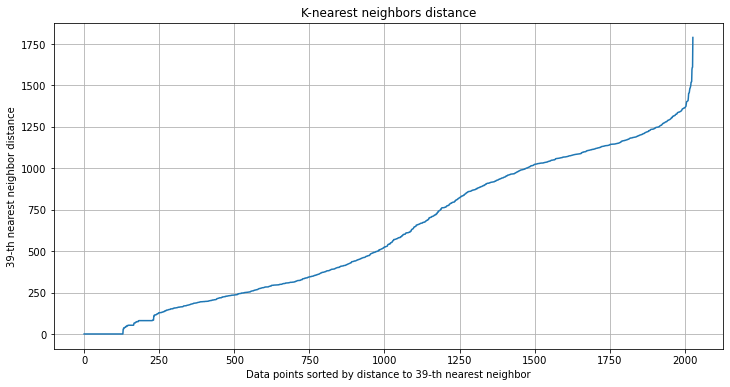

In [40]:
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt

# Assume X is your data matrix
min_samples = 40
neighbors = NearestNeighbors(n_neighbors=min_samples)
neighbors_fit = neighbors.fit(X)
distances, indices = neighbors_fit.kneighbors(X)

# Sort the distances
distances = np.sort(distances, axis=0)
distances = distances[:,1]  # Change 1 to min_samples-1 if different

plt.figure(figsize=(12, 6))
plt.plot(distances)
plt.xlabel('Data points sorted by distance to {}-th nearest neighbor'.format(min_samples-1))
plt.ylabel('{}-th nearest neighbor distance'.format(min_samples-1))
plt.title('K-nearest neighbors distance')
plt.grid(True)
plt.show()


# important to note- change between X_tsne and X_umap in each code cell.

In [53]:
%pip install numpy scikit-learn umap-learn pandas

import numpy as np
from sklearn.manifold import TSNE
from sklearn.cluster import DBSCAN
import pandas as pd
from umap import UMAP

random_state = 42
tsne = TSNE()
X_tsne = tsne.fit_transform(X)

# Initialize a UMAP instance with the given parameters.
umap = UMAP()
X_umap = umap.fit_transform(X)

dbscan = DBSCAN(eps=1300, min_samples=4)  # Adjust parameters as needed
clusters = dbscan.fit_predict(X_tsne)  # Or X_mds if using MDS
print(f'Number of clusters: {len(np.unique(clusters))}')


Note: you may need to restart the kernel to use updated packages.
Number of clusters: 1


Note: you may need to restart the kernel to use updated packages.


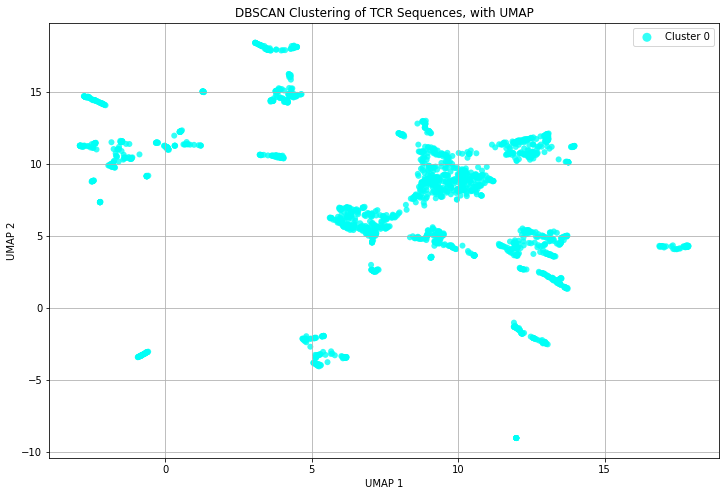

In [54]:

%pip install matplotlib seaborn

import matplotlib.pyplot as plt
import seaborn as sns  # Optional for improved aesthetics

# Assuming 'X_umap' is your dimensionality-reduced data and 'clusters' is the array of cluster labels from DBSCAN
plt.figure(figsize=(12, 8))  # Set the figure size as desired
unique_clusters = set(clusters)  # Identify unique clusters including the noise (-1)

# Generate a color palette with seaborn, one color for each cluster
palette = sns.color_palette('hsv', len(unique_clusters))  # 'hsv' is just one option for color space

# Plot each cluster
for cluster_id, color in zip(unique_clusters, palette):
    # Select data points that belong to the current cluster
    ix = clusters == cluster_id
    # Plot these data points with the cluster-specific color
    plt.scatter(X_umap[ix, 0], X_umap[ix, 1], c=[color], label=f'Cluster {cluster_id}', alpha=0.8, edgecolors='none')

plt.title('DBSCAN Clustering of TCR Sequences, with UMAP')
plt.xlabel('UMAP 1')  # Or 'MDS 1' if you used MDS
plt.ylabel('UMAP 2')  # Or 'MDS 2' if you used MDS
plt.legend(markerscale=1.5)  # Adjust marker scale for better visibility
plt.grid(True)  # Optional, adds a grid to the background
plt.show()


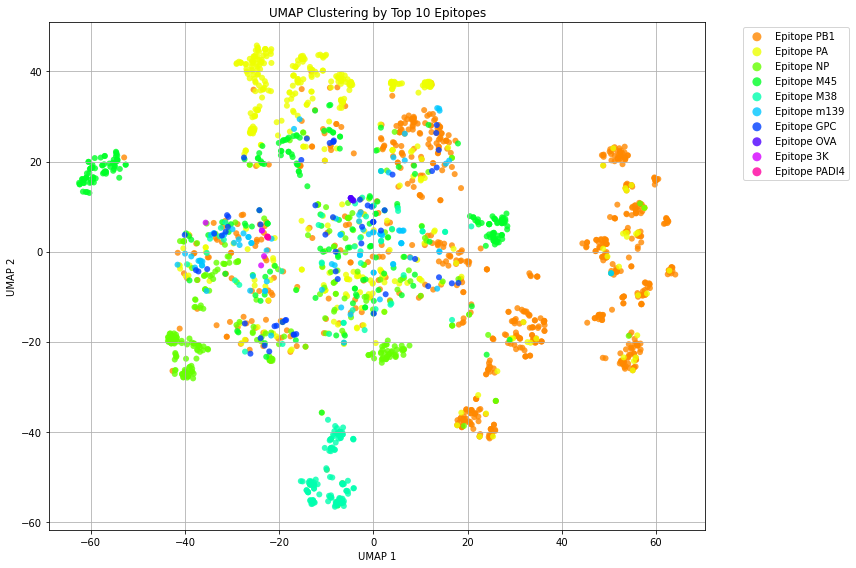

In [55]:
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

plt.figure(figsize=(12, 8))

# Assuming 'Y' is the array of epitope labels for each data point
epitope_counts = Counter(Y)
top_10_epitopes = [epitope for epitope, count in epitope_counts.most_common(10)]

# Generate a color palette with seaborn, one color for each of the top 10 epitopes
palette = sns.color_palette('hsv', len(top_10_epitopes))

# Create a dictionary mapping each of the top 10 epitopes to a color
epitope_to_color = {epitope: color for epitope, color in zip(top_10_epitopes, palette)}

# Plot each point for the top 10 epitopes
for epitope in top_10_epitopes:
    ix = [i for i, e in enumerate(Y) if e == epitope]  # Indices of points for the current epitope
    plt.scatter(X_tsne[ix, 0], X_tsne[ix, 1], c=[epitope_to_color[epitope]], label=f'Epitope {epitope}', alpha=0.8, edgecolors='none')

plt.title('UMAP Clustering by Top 10 Epitopes')
plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')
plt.legend(markerscale=1.5, bbox_to_anchor=(1.05, 1), loc='upper left')  # Adjust for better visibility and positioning
plt.grid(True)  # Optional
plt.tight_layout()  # Adjust layout to make room for the legend
plt.show()



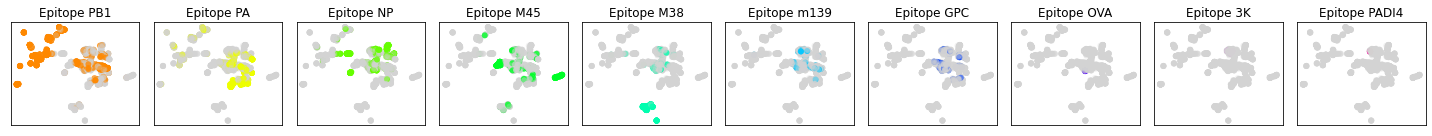

In [52]:
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

# Assuming 'Y' is your array of epitope labels and 'X_umap' is your UMAP-reduced data
epitope_counts = Counter(Y)
top_10_epitopes = [epitope for epitope, count in epitope_counts.most_common(10)]

# Set up the figure and axes for the subplots
fig, axes = plt.subplots(1, 10, figsize=(20, 2))  # Adjust figsize as needed

# Generate a color palette for the epitopes
palette = sns.color_palette('hsv', len(top_10_epitopes))

for i, epitope in enumerate(top_10_epitopes):
    # Plot each epitope in color and the rest in grey
    for j, e in enumerate(Y):
        if e == epitope:
            axes[i].scatter(X_umap[j, 0], X_umap[j, 1], color=palette[i], label=f'Epitope {epitope}', alpha=0.8, edgecolors='none')
        else:
            axes[i].scatter(X_umap[j, 0], X_umap[j, 1], color='lightgrey', alpha=0.3, edgecolors='none')

    axes[i].set_title(f'Epitope {epitope}')
    axes[i].set_xticks([])  # Hide x ticks
    axes[i].set_yticks([])  # Hide y ticks

# Adjust layout
plt.tight_layout()

# Display the plot
plt.show()


umap only


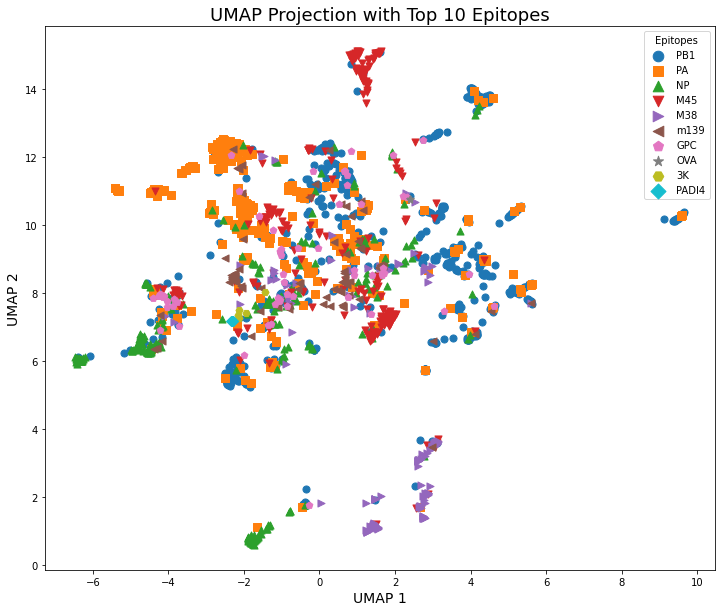

In [44]:
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter

# Assuming X_reduced contains your UMAP-reduced data and Y are your labels (epitopes)

# Find the top 10 most common epitopes
epitope_counts = Counter(Y)
top_epitopes = [epitope for epitope, count in epitope_counts.most_common(10)]

# Set up colors and markers
colors = plt.cm.tab10(np.linspace(0, 1, 10))  # 10 distinct colors
markers = ['o', 's', '^', 'v', '>', '<', 'p', '*', 'H', 'D']  # Different shapes for top epitopes

# Plot
plt.figure(figsize=(12, 10))

# Plot each of the top epitopes
for i, epitope in enumerate(top_epitopes):
    indices = np.where(Y == epitope)[0]
    plt.scatter(X_reduced[indices, 0], X_reduced[indices, 1], color=colors[i], marker=markers[i], label=epitope, s=50)

# Add details
plt.title('UMAP Projection with Top 10 Epitopes', fontsize=18)
plt.xlabel('UMAP 1', fontsize=14)
plt.ylabel('UMAP 2', fontsize=14)
plt.legend(markerscale=1.5, loc='best', title='Epitopes')
plt.show()


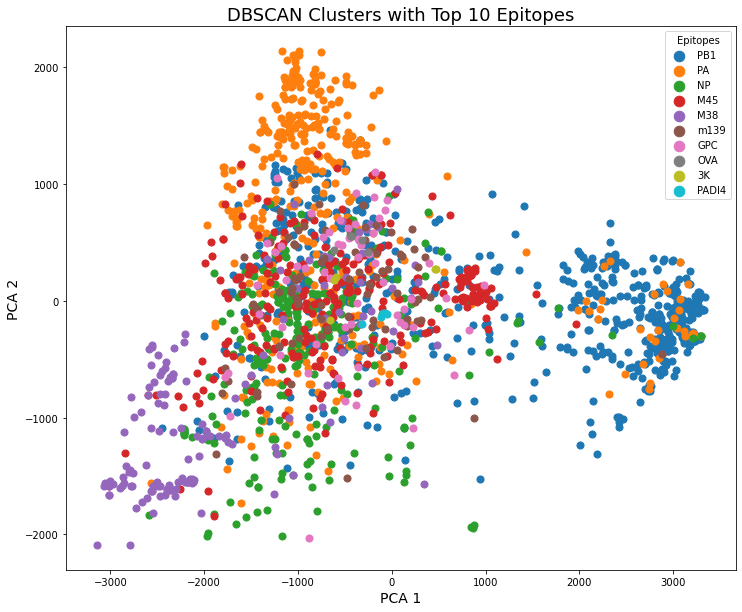

In [45]:
from sklearn.cluster import DBSCAN
from sklearn.decomposition import PCA  # If dimensionality reduction is needed

# If needed, reduce dimensionality (for example, with PCA)
pca = PCA(n_components=50)  # Adjust based on your data
X_pca = pca.fit_transform(X)  # Replace X with your original data

# Apply DBSCAN
dbscan = DBSCAN(eps=0.5, min_samples=10)  # Adjust parameters as necessary
clusters = dbscan.fit_predict(X_pca)  # Replace X_pca with X if not reducing dimensions

# Find the top 10 most common epitopes
epitope_counts = Counter(Y)
top_epitopes = [epitope for epitope, count in epitope_counts.most_common(10)]

# Plot
plt.figure(figsize=(12, 10))

# Plot each of the top epitopes within DBSCAN clusters
for i, epitope in enumerate(top_epitopes):
    indices = [j for j, label in enumerate(Y) if label == epitope]
    plt.scatter(X_pca[indices, 0], X_pca[indices, 1], color=colors[i], label=epitope, s=50)  # Adjust if using different reduced data

# Add details
plt.title('DBSCAN Clusters with Top 10 Epitopes, after PCA', fontsize=18)
plt.xlabel('PCA 1' if 'X_pca' in locals() else 'Feature 1', fontsize=14)  # Adjust based on reduction
plt.ylabel('PCA 2' if 'X_pca' in locals() else 'Feature 2', fontsize=14)  # Adjust based on reduction
plt.legend(markerscale=1.5, loc='best', title='Epitopes')
plt.show()


# All the same: but split up for mouse data 

In [49]:
%pip install git+https://github.com/kmayerb/tcrdist3.git@0.2.2
from tcrdist.repertoire import TCRrep
import pwseqdist as pw
from tcrdist.rep_funcs import _pws, _pw

from sklearn.model_selection import StratifiedKFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import roc_curve, auc, roc_auc_score, confusion_matrix, precision_score, recall_score, f1_score, accuracy_score

import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import pickle

import pandas as pd
df = pd.read_csv('vdjdb_full.txt', delimiter = '\t')
vdjdb = df.drop_duplicates()
vdjdb['antigen.gene'].value_counts()
vdjdb['species'].value_counts()
df_slim = vdjdb.iloc[:,[0,1,2,3,4,6,7,12]]
df_cleaned = df_slim.dropna(subset = ['cdr3.alpha','cdr3.beta'])
df_cleaned.rename(columns={'cdr3.alpha': 'cdr3_a_aa', 'cdr3.beta': 'cdr3_b_aa', 'v.alpha':'v_a_gene','j.alpha': 'j_a_gene','v.beta': 'v_b_gene','j.beta': 'j_b_gene','antigen.gene':'epitope'}, inplace=True)
df_cleaned['species'].value_counts()
# Filter rows where species column contains "mouse"
mouse_df = df_cleaned[df_cleaned['species'].str.contains('MusMusculus', case=False, na=False)]

# Create a new DataFrame with removed rows
removed_rows_df = df_cleaned[~df_cleaned.index.isin(mouse_df.index)]

mouse_df['species'].value_counts()
mouse_df.shape
# <chains> - tcrdist3 accepts ['alpha', 'beta'] or ['alpha'] or ['beta']
chains = ['alpha', 'beta']
# <cdr3> We can choose either 'cdr3' or 'all'. Choosing 'all' will
# compute distances using CDR1,CDR2, and CDR2.5 as well as CDR3
cdrs = 'all'
organism = 'mouse'
db_file = 'alphabeta_gammadelta_db.tsv'

# Initialize a list with the column names to consider when identifying duplicates to drop.
# Initially, it includes only the 'epitope' column.
drop_dup_cols = ['epitope']

# Add columns related to the alpha chain of the TCR if certain conditions are met.
# This depends on two factors: whether the 'alpha' chain is part of the analysis (indicated by 'alpha' in chains)
# and the level of detail being considered (CDR3 only or all features).
if 'alpha' in chains and cdrs=='cdr3':
    drop_dup_cols += ['cdr3_a_aa']  # Add only the CDR3 alpha amino acid sequence for duplication criteria.
elif 'alpha' in chains and cdrs=='all':
    drop_dup_cols += ['cdr3_a_aa', 'v_a_gene', 'j_a_gene']  # Add alpha chain CDR3, V gene, and J gene.

# Similarly, add columns related to the beta chain of the TCR if certain conditions are met.
if 'beta' in chains and cdrs=='cdr3':
    drop_dup_cols += ['cdr3_b_aa']  # Add only the CDR3 beta amino acid sequence for duplication criteria.
elif 'beta' in chains and cdrs=='all':
    drop_dup_cols += ['cdr3_b_aa', 'v_b_gene', 'j_b_gene']  # Add beta chain CDR3, V gene, and J gene.

# Drop duplicate rows based on the specified columns in 'drop_dup_cols'.
# 'keep='first'' means only the first occurrence is kept; subsequent duplicates are dropped.
# The result is copied to ensure a new DataFrame object is created.
df = mouse_df.drop_duplicates(subset=drop_dup_cols, keep='first').copy()

# Reset the index of the DataFrame to reflect the dropped rows, dropping the old index.
df.reset_index(drop=True, inplace=True)


df = df.drop(columns = 'species')
tr = TCRrep(cell_df=df,
            organism=organism,
            chains=chains,
            db_file=db_file,
            deduplicate=True)

# Initialize 'X' to None. 'X' will later store the matrix of distances,
# which is calculated based on the selected 'chains' and 'cdrs' criteria.
X = None

# If the analysis is to include all features of the TCR ('cdrs' set to 'all'),
# then the pairwise distances are calculated differently depending on the chains involved.
if cdrs == 'all':
    # For both alpha and beta chains, combine the pairwise distance matrices for both chains.
    if chains == ['alpha', 'beta'] or chains == ['beta', 'alpha']:
        X = pd.DataFrame(tr.pw_alpha + tr.pw_beta)
    # For alpha chain only, use the alpha chain pairwise distance matrix.
    elif chains == ['alpha']:
        X = pd.DataFrame(tr.pw_alpha)
    # For beta chain only, use the beta chain pairwise distance matrix.
    elif chains == ['beta']:
        X = pd.DataFrame(tr.pw_beta)

# If the analysis is focused on the CDR3 region only ('cdrs' set to 'cdr3'),
# then the pairwise distances are calculated based on CDR3 sequences.
if cdrs == 'cdr3':
    # For both alpha and beta chains, combine the pairwise distance matrices for CDR3 regions of both chains.
    if chains == ['alpha', 'beta'] or chains == ['beta', 'alpha']:
        X = pd.DataFrame(tr.pw_cdr3_a_aa + tr.pw_cdr3_b_aa)
    # For alpha chain only, use the CDR3 alpha region pairwise distance matrix.
    elif chains == ['alpha']:
        X = pd.DataFrame(tr.pw_cdr3_a_aa)
    # For beta chain only, use the CDR3 beta region pairwise distance matrix.
    elif chains == ['beta']:
        X = pd.DataFrame(tr.pw_cdr3_b_aa)

# Assert that 'X' is not None to ensure that a distance matrix has been assigned.
# This acts as a check to ensure that the preceding logic correctly assigned a distance matrix
# based on the specified 'chains' and 'cdrs' parameters.
assert X is not None
Y = tr.clone_df['epitope'].copy() # target labels




  Cloning https://github.com/kmayerb/tcrdist3.git (to revision 0.2.2) to /private/var/folders/vx/p6h8zj0n0wxd9qrn2pk09l9c0000gn/T/pip-req-build-_b2kmhvp
  Running command git clone -q https://github.com/kmayerb/tcrdist3.git /private/var/folders/vx/p6h8zj0n0wxd9qrn2pk09l9c0000gn/T/pip-req-build-_b2kmhvp
  Running command git checkout -q 04b0b8c2573d04a9d2cb77f7a3aeeed3a0eab167
  Resolved https://github.com/kmayerb/tcrdist3.git to commit 04b0b8c2573d04a9d2cb77f7a3aeeed3a0eab167
Note: you may need to restart the kernel to use updated packages.


/var/folders/vx/p6h8zj0n0wxd9qrn2pk09l9c0000gn/T/ipykernel_92787/4129680250.py:20: DtypeWarning: Columns (30) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('vdjdb_full.txt', delimiter = '\t')
/var/folders/vx/p6h8zj0n0wxd9qrn2pk09l9c0000gn/T/ipykernel_92787/4129680250.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned.rename(columns={'cdr3.alpha': 'cdr3_a_aa', 'cdr3.beta': 'cdr3_b_aa', 'v.alpha':'v_a_gene','j.alpha': 'j_a_gene','v.beta': 'v_b_gene','j.beta': 'j_b_gene','antigen.gene':'epitope'}, inplace=True)
/Users/joesouber/opt/anaconda3/lib/python3.9/site-packages/tcrdist/repertoire.py:159: UserWarning: cell_df needs a counts column to track clonal number of frequency

  self._validate_cell_df()
/Users/joesouber/opt/anaconda3/lib/python3.9/s